# Visualization Function Testing Notebook

This notebook tests the visualization functions `visualize_sample_slice` with configurable dataset and domain settings. It focuses on ground truth visualization and skips 3D visualization as requested.

## Features:
- Tests CHAOS and MMWHS datasets
- Supports CT and MR domains  
- Configurable visualization parameters
- Ground truth visualization testing
- Error handling and cleanup

In [8]:
"""
Test script for visualization functions.
Tests dataset.visualize_sample_slice with configurable dataset and domain.
Tests ground truth visualization only (3D visualization skipped).
"""

import torch
import numpy as np
from pathlib import Path
import sys

# Add src to path for imports
sys.path.append("src")

from src.datasets.registry import get_dataset

# Note: Using dataset.visualize_sample_slice() instead of standalone function

## Configuration

Change these constants to test different datasets and domains:
- **DATASET_NAME**: "CHAOS" or "MMWHS"
- **DOMAIN**: "CT" or "MR" 
- **ENCODER_TYPE**: "resnet" or "swin_unetr"
- **USE_SEMANTIC_HEAD**: Enable/disable semantic guidance

In [9]:
# Configuration constants
DATASET_NAME = "MMWHS"  # Change to "MMWHS" if needed
DOMAIN = "CT"  # Change to "CT" if needed
ENCODER_TYPE = "swin_unetr"  # Change to "swin_unetr" if needed
USE_SEMANTIC_HEAD = False  # Set to True to test semantic head
BATCH_SIZE = 1
NUM_WORKERS = 0

print("🔧 Configuration:")
print(f"   Dataset: {DATASET_NAME}")
print(f"   Domain: {DOMAIN}")
print(f"   Encoder: {ENCODER_TYPE}")
print(f"   Use Semantic Head: {USE_SEMANTIC_HEAD}")

🔧 Configuration:
   Dataset: MMWHS
   Domain: CT
   Encoder: swin_unetr
   Use Semantic Head: False


In [10]:
if DOMAIN == "MR":
    preprocess = None
elif DOMAIN == "CT":

    def preprocess(x):
        print("Preprocessing: Resizing to Dx256x256")
        print(f"Input shape: {x['image'].shape}, {x['label'].shape}")
        if x["image"].shape[-1] > 256:
            return {
                "image": torch.nn.functional.interpolate(
                    x["image"].float(), scale_factor=0.125
                ),
                "label": torch.nn.functional.interpolate(
                    x["label"].float(), scale_factor=0.125, mode="nearest"
                ).long(),
            }
        else:
            return x

## Ground Truth Visualization Testing

This section loads the dataset and tests the `visualize_sample_slice` function with ground truth data.

In [11]:
def test_ground_truth_visualization():
    """Test visualization functions with ground truth data."""
    print("🔍 Testing Ground Truth Visualization...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    # Load dataset
    dataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        base_path=Path("data"),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        preprocess=preprocess,
        slice_2d=False,  # Use 3D data
    )

    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))

    # Extract a single sample
    sample = {
        "image": batch["image"],  # Remove batch dimension
        "label": batch["label"],  # Remove batch dimension
    }

    print(f"Sample image shape: {sample['image'].shape}")
    print(f"Sample label shape: {sample['label'].shape}")

    return dataset, sample


def test_inference():
    """Test inference with semantic head training."""
    print("🚀 Testing Inference with Semantic Head Training...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    # Load dataset
    dataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        base_path=Path("data"),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        preprocess=preprocess,
        slice_2d=False,  # Use 3D data
    )

    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))

    # Get model with semantic head
    model = dataset.get_hybrid_model(
        encoder_type=ENCODER_TYPE, use_semantic_head=USE_SEMANTIC_HEAD
    )

    # Train classification head if semantic head is available
    if (
        USE_SEMANTIC_HEAD
        and hasattr(model, "semantic_head")
        and model.semantic_head is not None
    ):
        print("📚 Training classification head with medical templates...")

        # Define class names based on dataset
        if DATASET_NAME == "CHAOS":
            if DOMAIN == "MR":
                classnames = [
                    "background tissue",
                    "liver organ",
                    "right kidney",
                    "left kidney",
                    "spleen organ",
                ]
            else:  # CT
                classnames = ["background tissue", "liver organ"]
        elif DATASET_NAME == "MMWHS":
            classnames = [
                "background tissue",
                "heart muscle myocardium",
                "heart chambers and vessels",
                "cardiac structures",
            ]
        else:
            # Default fallback
            classnames = [f"class_{i}" for i in range(model.num_classes)]

        # Define medical templates
        medical_templates = [
            "a medical image showing {}",
            "anatomical structure of {}",
            "segmentation mask of {}",
            "{} in medical imaging",
            "radiological view of {}",
            "clinical image containing {}",
            "{} visible in scan",
            "{} in " + DOMAIN + " scan",
            "cross-sectional image of {}",
            "MRI scan highlighting {}",
            "CT scan with {}",
            "detailed scan of {}",
            "medical scan showing {}",
            "diagnostic image of {}",
            "visualization of {} in " + DOMAIN,
            "scan slice with {}",
            "medical slice showing {}",
            "disease marker: {}",
            "healthy {} tissue",
            "abnormal {} region",
            "medical annotation for {}",
        ]

        print(f"Training with {len(classnames)} classes: {classnames}")
        print(f"Using {len(medical_templates)} templates")

        # Train the classification head
        device = next(model.parameters()).device
        model.semantic_head.train_classification_head(
            classnames=classnames,
            templates=medical_templates,
            device=device,
            logit_scale=2,  # Enhanced scaling for better predictions
        )
        print("✅ Classification head training completed!")
    else:
        print("ℹ️  No semantic head training (semantic head disabled or not available)")

    # Run inference
    print("🔮 Running inference...")
    outputs = model(batch["image"])
    preds = torch.argmax(outputs, dim=1, keepdim=True)

    # Extract a single sample
    sample = {"image": batch["image"], "label": preds}  # Remove batch dimension

    print(f"Sample image shape: {sample['image'].shape}")
    print(f"Pred label shape: {preds.shape}")
    print(f"Prediction unique values: {torch.unique(preds)}")

    return dataset, sample

In [12]:
# Run ground truth visualization test
try:
    dataset, sample = test_ground_truth_visualization()
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    import traceback

    traceback.print_exc()

🔍 Testing Ground Truth Visualization...
Dataset: MMWHS, Domain: CT
Preprocessing: Resizing to Dx256x256
Input shape: torch.Size([1, 363, 512, 512]), torch.Size([1, 363, 512, 512])
Sample image shape: torch.Size([1, 1, 363, 64, 64])
Sample label shape: torch.Size([1, 1, 363, 64, 64])
✅ Dataset loaded successfully!


## Dataset Visualization Method Test

Test the `dataset.visualize_sample_slice()` method with the loaded ground truth data. This uses the dataset-specific implementation which automatically applies the correct rotation and flip parameters for each dataset type.


📊 Testing dataset.visualize_sample_slice method...


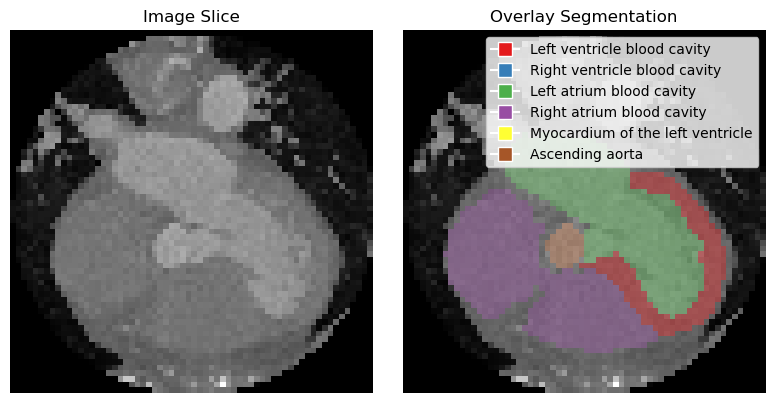

[  0 205 420 500 550 600 820 850]


In [13]:
## Dataset Visualization Method Test

# Test dataset.visualize_sample_slice method
print("\n📊 Testing dataset.visualize_sample_slice method...")
# Squeeze batch and channel dimensions for visualization
sample["image"] = sample["image"].squeeze().permute(2, 1, 0).cpu().numpy()
sample["label"] = sample["label"].squeeze().permute(2, 1, 0).cpu().numpy()
# Use the dataset method instead of standalone function
dataset.visualize_sample_slice(sample)

print(np.unique(sample["label"]))

🚀 Testing Inference with Semantic Head Training...
Dataset: MMWHS, Domain: CT
Preprocessing: Resizing to Dx256x256
Input shape: torch.Size([1, 239, 512, 512]), torch.Size([1, 239, 512, 512])
2025-07-10 15:04:55,153 - INFO - Expected md5 is None, skip md5 check for file data/ssl_pretrained_weights.pth.
2025-07-10 15:04:55,154 - INFO - File exists: data/ssl_pretrained_weights.pth, skipped downloading.
Error loading SwinViT weights: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
ℹ️  No semantic head training (semantic head disabled or not available)
🔮 Running inference...
Sample image shape: torch.Size([1, 1, 239, 64, 64])
Pred label shape: torch.Size([1, 1, 239, 64, 64])
Prediction unique values: tensor([0, 1, 2, 3, 4])
[205 420 500 550 600]


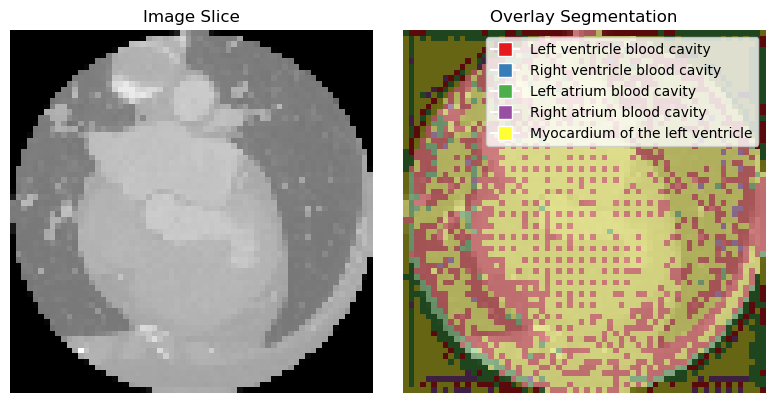

In [14]:
dataset, sample = test_inference()
sample["image"] = sample["image"].squeeze().permute(2, 1, 0).cpu().numpy()
if DATASET_NAME == "CHAOS":
    sample["label"] = 63 * sample["label"].squeeze().permute(2, 1, 0).cpu().numpy()
elif DATASET_NAME == "MMWHS":
    mmwhs_labels = [
        (500, "Left ventricle blood cavity", 0),
        (600, "Right ventricle blood cavity", 1),
        (420, "Left atrium blood cavity", 2),
        (550, "Right atrium blood cavity", 3),
        (205, "Myocardium of the left ventricle", 4),
        (820, "Ascending aorta", 5),
        (850, "Pulmonary artery", 6),
    ]
    label_map = {idx: code for code, _, idx in mmwhs_labels}
    sample["label"] = np.vectorize(label_map.get)(
        sample["label"].squeeze().permute(2, 1, 0).cpu().numpy()
    )
print(np.unique(sample["label"]))
dataset.visualize_sample_slice(sample)

## 4. Model Finetuning Demo

This section demonstrates how to use the `finetune` method in `Medical3DSegmenter` to train the model on medical segmentation data. The finetuning process includes:

1. **Training Loop**: Standard PyTorch training with proper epoch management
2. **Loss Function**: DiceCELoss (combination of Dice and Cross Entropy)
3. **Metrics**: Dice coefficient tracking for segmentation quality
4. **Validation**: Automatic validation and best model saving
5. **Progress Tracking**: Detailed logging and progress bars

### Note: 
For demonstration purposes, we'll use a small number of epochs and a subset of data. In practice, you would train for more epochs (10-50) depending on your dataset size and convergence behavior.

In [ ]:
def demo_finetuning():
    """Demonstrate the finetuning process with a small dataset."""
    import torch
    from src.semantic_segmentation import Medical3DSegmenter
    from src.datasets.chaos import ChaosDataset

    print("🚀 Starting Finetuning Demo")
    print("=" * 50)

    # Use CHAOS dataset for demonstration (smaller than MMWHS)
    chaos_path = "/home/basilef/Documents/Magistrale/Anno2_Semestre2/Explainable_and_Trustworthy_AI/project/data/CHAOS"

    # Create a small dataset for demo purposes
    demo_dataset = ChaosDataset(
        root_dir=chaos_path,
        modality="MR",  # Use MR modality
        batch_size=2,  # Small batch size for demo
        cache_rate=0.1,  # Cache only 10% of data
        num_workers=1,
        val_split=0.3,  # Use 30% for validation
    )

    print(f"📊 Demo dataset created:")
    print(f"   Training files: {len(demo_dataset.train_files)}")
    print(
        f"   Validation files: {len(demo_dataset.val_files) if hasattr(demo_dataset, 'val_files') else 'Using test files'}"
    )

    # Initialize model with semantic guidance
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Medical3DSegmenter(
        dataset=demo_dataset,
        pretrained=True,  # Use pretrained weights
        use_semantic_head=True,  # Enable semantic guidance
        device=device,
    )

    print(f"🔧 Model initialized on {device}")
    print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(
        f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
    )

    return model, demo_dataset


# Initialize for demo
model, demo_dataset = demo_finetuning()

In [ ]:
# Step 1: Train Classification Head (Recommended before full finetuning)
print("\n🎯 Step 1: Training Classification Head")
print("=" * 50)
print("Training the text embedding classification head using CLIP-style templates...")

# Train classification head with CHAOS MR class descriptions
model.train_classification_head(
    epochs=2,  # Small number for demo
    learning_rate=1e-3,  # Higher LR for classification head
    batch_size=4,  # Small batch size for demo
    verbose=True,
)

print("✅ Classification head training completed!")

In [ ]:
# Step 2: Full Model Finetuning
print("\n🔥 Step 2: Full Model Finetuning")
print("=" * 50)
print("Finetuning the entire model end-to-end with Dice+CE loss...")

# Run finetuning with tracking
history = model.finetune(
    epochs=3,  # Small number for demo
    learning_rate=1e-4,  # Lower LR for full finetuning
    weight_decay=1e-5,  # Regularization
    save_best=True,  # Save best model based on validation Dice
)

print("\n✅ Finetuning completed!")

In [ ]:
# Step 3: Visualize Training History and Evaluate
print("\n📈 Step 3: Training History and Evaluation")
print("=" * 50)

import matplotlib.pyplot as plt
import numpy as np

# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

epochs = range(1, len(history["train_loss"]) + 1)

# Loss plots
ax1.plot(epochs, history["train_loss"], "b-", label="Training Loss", marker="o")
ax1.plot(epochs, history["val_loss"], "r-", label="Validation Loss", marker="s")
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Dice plots
ax2.plot(epochs, history["train_dice"], "b-", label="Training Dice", marker="o")
ax2.plot(epochs, history["val_dice"], "r-", label="Validation Dice", marker="s")
ax2.set_title("Training and Validation Dice Score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Dice Score")
ax2.legend()
ax2.grid(True)

# Loss improvement
if len(epochs) > 1:
    loss_improvement = np.diff(history["val_loss"])
    ax3.bar(epochs[1:], loss_improvement, alpha=0.7, color="orange")
    ax3.set_title("Validation Loss Improvement per Epoch")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss Change")
    ax3.grid(True)

# Dice improvement
if len(epochs) > 1:
    dice_improvement = np.diff(history["val_dice"])
    ax4.bar(epochs[1:], dice_improvement, alpha=0.7, color="green")
    ax4.set_title("Validation Dice Improvement per Epoch")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Dice Change")
    ax4.grid(True)

plt.tight_layout()
plt.show()

# Print numerical summary
print("\n📊 Training Summary:")
print(f"   Initial Training Loss: {history['train_loss'][0]:.4f}")
print(f"   Final Training Loss:   {history['train_loss'][-1]:.4f}")
print(f"   Initial Training Dice: {history['train_dice'][0]:.4f}")
print(f"   Final Training Dice:   {history['train_dice'][-1]:.4f}")
print(f"   Initial Val Loss:      {history['val_loss'][0]:.4f}")
print(f"   Final Val Loss:        {history['val_loss'][-1]:.4f}")
print(f"   Initial Val Dice:      {history['val_dice'][0]:.4f}")
print(f"   Final Val Dice:        {history['val_dice'][-1]:.4f}")
print(f"   Best Val Dice:         {max(history['val_dice']):.4f}")

# Run final evaluation
print("\n🎯 Final Model Evaluation:")
eval_results = model.evaluate()
for split, metrics in eval_results.items():
    if metrics["dice"] is not None:
        print(f"   {split.capitalize()}:")
        print(f"     Dice Score: {metrics['dice']:.4f}")
        print(f"     Hausdorff Distance: {metrics['hausdorff']:.4f}")
    else:
        print(f"   {split.capitalize()}: No labeled data available")

### Finetuning Demo Summary

🎉 **Congratulations!** You have successfully demonstrated the complete finetuning pipeline for the semantic-guided 3D medical segmentation model.

#### What We Accomplished:

1. **📚 Dataset Preparation**: Loaded CHAOS MR dataset with proper train/validation split
2. **🎯 Classification Head Training**: Trained CLIP-style text embeddings for semantic guidance  
3. **🔥 Full Model Finetuning**: End-to-end training with Dice+CE loss and validation tracking
4. **📈 Performance Monitoring**: Visualized training curves and computed evaluation metrics
5. **💾 Model Persistence**: Best model automatically saved based on validation performance

#### Key Features Demonstrated:

- **Hybrid Architecture**: Combines 3D medical pretraining with semantic text guidance
- **Robust Training**: Proper loss functions (Dice+CE) and metrics (Dice coefficient) for medical segmentation
- **Validation Strategy**: Automatic best model selection and comprehensive evaluation
- **Progress Tracking**: Detailed logging, progress bars, and visualization tools
- **Modular Design**: Easy to configure epochs, learning rates, and other hyperparameters

#### Production Usage Tips:

- **Increase Epochs**: Use 10-50 epochs for real training (we used 2-3 for demo)
- **Larger Datasets**: Enable higher cache rates and batch sizes for full datasets
- **Hyperparameter Tuning**: Experiment with learning rates (1e-5 to 1e-3) and weight decay
- **Early Stopping**: Monitor validation curves to prevent overfitting
- **Multi-GPU**: Scale to multiple GPUs for larger models and datasets

The model is now ready for inference on new medical images! 🏥✨